In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

import sys

from importlib import reload

import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)s | %(name)s | %(levelname)s : %(message)s',
    level=logging.INFO,
    stream=sys.stdout
)

logger = logging.getLogger('hysped')
logger.setLevel(logging.DEBUG)

import contextily as ctx
import geocube
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import re
import seaborn as sns
import shapely
import tensorflow as tf
import visualkeras
import zipfile

import wandb
wandb.login()

from functools import partial
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial
from IPython.display import JSON, HTML
from keras.utils.np_utils import to_categorical
from matplotlib.colors import to_rgba
from shapely.geometry import box, mapping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tqdm.notebook import trange, tqdm
from wandb.keras import WandbMetricsLogger, WandbEvalCallback, WandbModelCheckpoint


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # configure utilization of GPUs
    try:
        for gpu in gpus:
            # memory growth setting
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.set_logical_device_configuration(
                gpu,
                [tf.config.LogicalDeviceConfiguration(memory_limit=256)]
            )
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        module_logger.error(e)


# Make numpy values easier to read.
np.set_printoptions(precision=6, suppress=True)

%matplotlib inline

wandb: Currently logged in as: stevo (hysped). Use `wandb login --relogin` to force relogin


In [2]:
def mkdir(path):
    if not os.path.isdir(path):
        if not os.path.exists(path):
            os.mkdir(path)
            
def predict_model(m, X, Y, label_encoder):
    Y_pred = m.predict(X)
    Y_pred = np.argmax(Y_pred, axis=1)
    Y_pred = label_encoder.inverse_transform(Y_pred)
    Y_pred = pd.DataFrame(Y_pred, columns=['Y_pred'])
    return Y_pred

def plot_cm(ax, cm, labels, title='Confusion Matrix'):
    sns.heatmap(
        cm,
        annot=True,
        fmt='g',
        ax=ax,
        cmap='Blues',
        # square=True,
        xticklabels=labels,
        yticklabels=labels,
        linewidths=1,
        # annot_kws={'size': 12}
    )

    ax.set_title(title)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

## Configuration

In [3]:
cfg = dict(
    data_dir = os.path.join('..', 'data', 'Sverepec_spolu_preprocessed_SM'),
    models_dir = os.path.join('..', 'models'),
    class_column = 'DRUH_DR',
    model_name = 'conv1D_SM',
    num_conv1D_layers = 4,
)
cfg['project_name'] = 'hysped-%s' % cfg['model_name']

mkdir(cfg['models_dir'])
display(JSON(cfg, expanded=True))

<IPython.core.display.JSON object>

## Load data

In [4]:
X_train = pd.read_parquet(os.path.join(cfg['data_dir'], 'X_train.parquet'))
Y_train = pd.read_parquet(os.path.join(cfg['data_dir'], 'Y_train.parquet'))
X_val = pd.read_parquet(os.path.join(cfg['data_dir'], 'X_val.parquet'))
Y_val = pd.read_parquet(os.path.join(cfg['data_dir'], 'Y_val.parquet'))

label_encoder = LabelEncoder()
encoder_filename = os.path.join(cfg['data_dir'], 'encoder-%s.npy' % cfg['class_column'])
label_encoder.classes_ = np.load(encoder_filename, allow_pickle=True)

num_classes = len(label_encoder.classes_)

X_train = X_train.values
Y_train = to_categorical(
    label_encoder.transform(Y_train[cfg['class_column']]),
    num_classes=num_classes
)

X_val = X_val.values
Y_val = to_categorical(
    label_encoder.transform(Y_val[cfg['class_column']]),
    num_classes=num_classes
)

## Model architecture

In [5]:
def make_model(
    input_shape: tuple,
    filters: [int],
    kernel_sizes: [int],
    num_classes: int,
    padding: str,
    **kwargs
):
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.Input(
            shape=input_shape
        )
    )
    model.add(
        tf.keras.layers.BatchNormalization()
    )
    
    for f,k in zip(filters, kernel_sizes):
        model.add(
            tf.keras.layers.Conv1D(
                filters=f,
                kernel_size=k,
                activation=tf.nn.relu,
                padding=padding
            )
        )
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
        
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(num_classes * 2))
    model.add(tf.keras.layers.Dense(num_classes))
    model.add(tf.keras.layers.Softmax())
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model

## Train model

In [6]:
config = dict(
    input_shape=(X_train.shape[1], 1),   
    filters=[512,256,128,64],
    kernel_sizes=[9,7,5,3],
    num_classes=Y_train.shape[1],
    padding='causal'
)

run = wandb.init(
    project=cfg['project_name'],
    config=config
)
logger.info('run.id: %s, run.name: %s' % (run.id, run.name))

model = make_model(**run.config)
model.summary()

model_dir = os.path.join(cfg['models_dir'], cfg['model_name'])
mkdir(model_dir)
logger.info('model_dir: %s' % model_dir)
model_file = os.path.join(model_dir, 'run_%s_model.h5' % (run.id))
logger.info('model_file: %s' % model_file)

wandbModelCheckpoint = WandbModelCheckpoint(
    model_file,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True
)

callbacks = [
    WandbMetricsLogger(),
    wandbModelCheckpoint,
]

history = model.fit(
    x=X_train,
    y=Y_train,
    validation_data=(X_val, Y_val),
    epochs=50,
    shuffle=True,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

run.finish()
wandb.finish()

2023-04-07 20:43:04,291 | hysped | INFO : run.id: qdvj4i1m, run.name: polished-shape-1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 186, 1)           4         
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 186, 512)          5120      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 93, 512)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 93, 256)           917760    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 46, 256)          0         
 1D)                               

wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Epoch 1/50
168/168 [==============================] - 10s 32ms/step - loss: 0.3933 - categorical_accuracy: 0.8231 - val_loss: 1.0186 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 5s 27ms/step - loss: 0.3040 - categorical_accuracy: 0.8820 - val_loss: 1.0219 - val_categorical_accuracy: 0.5026
Epoch 3/50
168/168 [==============================] - 5s 27ms/step - loss: 0.2590 - categorical_accuracy: 0.9038 - val_loss: 0.6924 - val_categorical_accuracy: 0.6812
Epoch 4/50
168/168 [==============================] - 5s 27ms/step - loss: 0.2323 - categorical_accuracy: 0.9170 - val_loss: 0.5028 - val_categorical_accuracy: 0.7772
Epoch 5/50
168/168 [==============================] - 5s 27ms/step - loss: 0.2041 - categorical_accuracy: 0.9286 - val_loss: 0.2378 - val_categorical_accuracy: 0.9092
Epoch 6/50
168/168 [==============================] - 5s 27ms/step - loss: 0.1869 - categorical_accuracy: 0.9365 - val_loss: 0.1812 - val_categorical_accuracy: 0.93

epoch/categorical_accuracy,▁▄▅▆▇▇▇▇▇▇▇▇████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▄▅████████████████████████████████████
epoch/val_loss,██▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/categorical_accuracy,0.96355
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.10739
epoch/val_categorical_accuracy,0.96683


## Confusion matrix

288/288 [==============================] - 2s 6ms/step


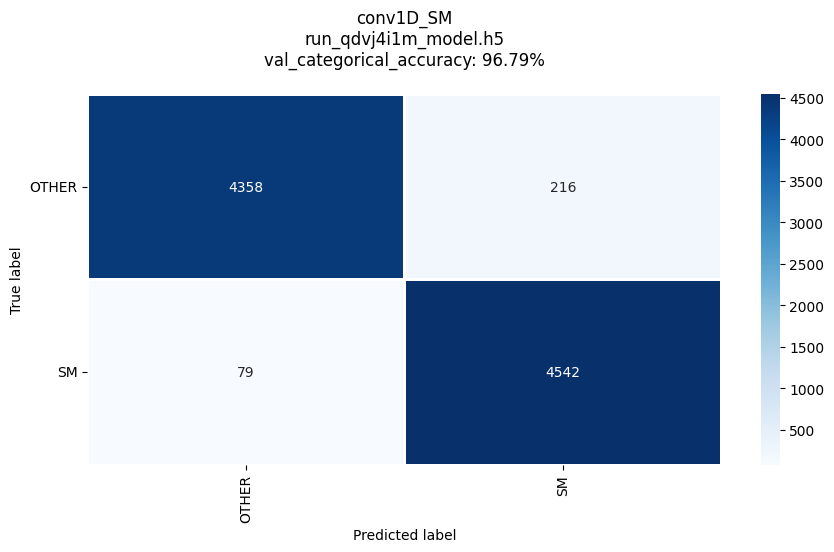

In [7]:
# load the best model
m = tf.keras.models.load_model(wandbModelCheckpoint.filepath)

Y_pred = predict_model(m, X_val, Y_val, label_encoder=label_encoder)
cm = confusion_matrix(label_encoder.inverse_transform(np.argmax(Y_val, axis=1)), Y_pred)

fig, ax = plt.subplots(figsize=(9,5))
plot_cm(ax, cm, labels=label_encoder.classes_)
plt.title('%s\n%s\n%s: %.2f%%\n' % (cfg['model_name'], os.path.basename(model_file), wandbModelCheckpoint.monitor, wandbModelCheckpoint.best * 100.0))
plt.show()

## Hyperparameter tuning

In [6]:
# Define the search space
sweep_configuration = {
    'method': 'random',
    'metric': {
        'goal': 'maximize',
        'name': 'val_categorical_accuracy'
    },
    'parameters': {
        'input_shape': {
            'values': [(X_train.shape[1], 1)]
        },
        'num_classes': {
            'values': [num_classes]
        },
        'kernel_sizes': {
            'values': [
                [kernel_size for conv1d_layer in range(cfg['num_conv1D_layers'])] for kernel_size in [3,5,7,9,11,13,15]
            ]
        },
        'filters': {
            'values': [
                [2**(conv1d_layer+i) for conv1d_layer in range(cfg['num_conv1D_layers'],0,-1)] for i in range(8)
            ]
        },
        'batch_size': {
            'values': [
                128
            ]
        },
        'padding': {
            'values': [
                'causal'
            ]
        }
    }
}

display(JSON(sweep_configuration, expanded=True))

<IPython.core.display.JSON object>

In [7]:
def main():
    run = wandb.init(project=cfg['project_name'])
    model = make_model(**wandb.config)
    
    model_dir = os.path.join(cfg['models_dir'], cfg['model_name'])
    mkdir(model_dir)
    logger.info('model_dir: %s' % model_dir)
    model_file = os.path.join(model_dir, 'run_%s_model.h5' % (run.id))
    logger.info('model_file: %s' % model_file)
    
    wandbModelCheckpoint = WandbModelCheckpoint(
        model_file,
        monitor='val_categorical_accuracy',
        mode='max',
        save_best_only=True
    )

    callbacks = [
        WandbMetricsLogger(),
        wandbModelCheckpoint,
    ]

    history = model.fit(
        x=X_train,
        y=Y_train,
        validation_data=(X_val, Y_val),
        epochs=50,
        shuffle=True,
        batch_size=wandb.config.batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    wandb.log({
        wandbModelCheckpoint.monitor: wandbModelCheckpoint.best
    })
    run.finish()
    # wandb.log(pd.DataFrame(history.history)[-1:].reset_index(drop=True).to_dict(orient='records')[0])

# Start the sweep
sweep_id = wandb.sweep(
    sweep=sweep_configuration,
    project=cfg['project_name']
)
wandb.agent(sweep_id, function=main, count=50)
wandb.finish()

Create sweep with ID: i5mp3h1h
Sweep URL: https://wandb.ai/hysped/hysped-conv1D_SM/sweeps/i5mp3h1h
2023-04-08 12:10:46,300 | wandb.agents.pyagent | INFO : Starting sweep agent: entity=None, project=None, count=50


wandb: Agent Starting Run: es9a32fx with config:
wandb: 	batch_size: 128
wandb: 	filters: [32, 16, 8, 4]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [11, 11, 11, 11]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 12:10:50,366 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 12:10:50,368 | hysped | INFO : model_file: ../models/conv1D_SM/run_es9a32fx_model.h5


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Epoch 1/50
168/168 [==============================] - 10s 21ms/step - loss: 0.4573 - categorical_accuracy: 0.7933 - val_loss: 0.7360 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3886 - categorical_accuracy: 0.8364 - val_loss: 0.7528 - val_categorical_accuracy: 0.5027
Epoch 3/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3236 - categorical_accuracy: 0.8790 - val_loss: 0.6088 - val_categorical_accuracy: 0.6524
Epoch 4/50
168/168 [==============================] - 3s 17ms/step - loss: 0.2781 - categorical_accuracy: 0.8971 - val_loss: 0.5565 - val_categorical_accuracy: 0.6933
Epoch 5/50
168/168 [==============================] - 3s 17ms/step - loss: 0.2682 - categorical_accuracy: 0.9006 - val_loss: 0.2219 - val_categorical_accuracy: 0.9138
Epoch 6/50
168/168 [==============================] - 3s 17ms/step - loss: 0.2510 - categorical_accuracy: 0.9071 - val_loss: 0.2091 - val_categorical_accuracy: 0.92

epoch/categorical_accuracy,▁▃▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▃▄▇█▇█████████████████████████████████
epoch/val_loss,██▆▆▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.94948
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.15449


wandb: Agent Starting Run: 5sub1v30 with config:
wandb: 	batch_size: 128
wandb: 	filters: [256, 128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [3, 3, 3, 3]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 12:13:31,106 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 12:13:31,107 | hysped | INFO : model_file: ../models/conv1D_SM/run_5sub1v30_model.h5
Epoch 1/50
168/168 [==============================] - 7s 26ms/step - loss: 0.4014 - categorical_accuracy: 0.8186 - val_loss: 0.8009 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3552 - categorical_accuracy: 0.8492 - val_loss: 0.7682 - val_categorical_accuracy: 0.5039
Epoch 3/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3016 - categorical_accuracy: 0.8836 - val_loss: 0.5866 - val_categorical_accuracy: 0.7393
Epoch 4/50
168/168 [==============================] - 3s 17ms/step - loss: 0.2779 - categorical_accuracy: 0.8940 - val_loss: 0.5528 - val_categorical_accuracy: 0.7359
Epoch 5/50
168/168 [==============================] - 3s 18ms/step - loss: 0.2661 - categorical_accuracy: 0.9004 - val_loss: 0.2349 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇█▇▇█████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▅▅▇▇▇█▇███████████████████████████████
epoch/val_loss,██▆▅▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.954
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.13722


wandb: Agent Starting Run: e9e705eq with config:
wandb: 	batch_size: 128
wandb: 	filters: [1024, 512, 256, 128]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [5, 5, 5, 5]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 12:16:11,926 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 12:16:11,927 | hysped | INFO : model_file: ../models/conv1D_SM/run_e9e705eq_model.h5
Epoch 1/50
168/168 [==============================] - 15s 69ms/step - loss: 0.3817 - categorical_accuracy: 0.8315 - val_loss: 0.8086 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 10s 61ms/step - loss: 0.2870 - categorical_accuracy: 0.8905 - val_loss: 0.5393 - val_categorical_accuracy: 0.6763
Epoch 3/50
168/168 [==============================] - 10s 60ms/step - loss: 0.2396 - categorical_accuracy: 0.9131 - val_loss: 0.5918 - val_categorical_accuracy: 0.6566
Epoch 4/50
168/168 [==============================] - 10s 62ms/step - loss: 0.2180 - categorical_accuracy: 0.9222 - val_loss: 0.2819 - val_categorical_accuracy: 0.8783
Epoch 5/50
168/168 [==============================] - 10s 62ms/step - loss: 0.1871 - categorical_accuracy: 0.9359 - val_loss: 0.1632 - val_categorical_accuracy

epoch/categorical_accuracy,▁▄▅▆▇▇▇▇▇▇▇█████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▄▃▇████████████████████████████████████
epoch/val_loss,█▅▆▃▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96239
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.1123


wandb: Agent Starting Run: 74ledk8g with config:
wandb: 	batch_size: 128
wandb: 	filters: [64, 32, 16, 8]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [13, 13, 13, 13]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 12:24:56,865 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 12:24:56,867 | hysped | INFO : model_file: ../models/conv1D_SM/run_74ledk8g_model.h5
Epoch 1/50
168/168 [==============================] - 6s 23ms/step - loss: 0.4274 - categorical_accuracy: 0.8066 - val_loss: 0.7232 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3223 - categorical_accuracy: 0.8704 - val_loss: 0.6187 - val_categorical_accuracy: 0.6147
Epoch 3/50
168/168 [==============================] - 3s 17ms/step - loss: 0.2586 - categorical_accuracy: 0.9071 - val_loss: 0.3792 - val_categorical_accuracy: 0.8213
Epoch 4/50
168/168 [==============================] - 3s 17ms/step - loss: 0.2353 - categorical_accuracy: 0.9184 - val_loss: 0.2115 - val_categorical_accuracy: 0.9244
Epoch 5/50
168/168 [==============================] - 3s 17ms/step - loss: 0.2112 - categorical_accuracy: 0.9274 - val_loss: 0.1789 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▄▆▆▇▇▇▇▇▇▇▇▇▇▇██▇██████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▃▆▇████████████████████████████████████
epoch/val_loss,█▇▄▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.95502
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.13525


wandb: Agent Starting Run: 6h8g3a68 with config:
wandb: 	batch_size: 128
wandb: 	filters: [128, 64, 32, 16]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [9, 9, 9, 9]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 12:27:37,676 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 12:27:37,677 | hysped | INFO : model_file: ../models/conv1D_SM/run_6h8g3a68_model.h5
Epoch 1/50
168/168 [==============================] - 7s 27ms/step - loss: 0.4168 - categorical_accuracy: 0.8104 - val_loss: 0.9019 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3331 - categorical_accuracy: 0.8661 - val_loss: 0.9022 - val_categorical_accuracy: 0.5026
Epoch 3/50
168/168 [==============================] - 3s 18ms/step - loss: 0.2877 - categorical_accuracy: 0.8896 - val_loss: 0.5709 - val_categorical_accuracy: 0.6989
Epoch 4/50
168/168 [==============================] - 3s 18ms/step - loss: 0.2384 - categorical_accuracy: 0.9141 - val_loss: 0.3240 - val_categorical_accuracy: 0.8501
Epoch 5/50
168/168 [==============================] - 3s 18ms/step - loss: 0.2201 - categorical_accuracy: 0.9237 - val_loss: 0.2552 - val_categorical_accuracy: 0.8

epoch/categorical_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇██████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▄▆████████████████████████████████████
epoch/val_loss,██▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96309
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.11238


wandb: Agent Starting Run: qr0ayg0m with config:
wandb: 	batch_size: 128
wandb: 	filters: [32, 16, 8, 4]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [5, 5, 5, 5]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 12:30:19,443 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 12:30:19,444 | hysped | INFO : model_file: ../models/conv1D_SM/run_qr0ayg0m_model.h5
Epoch 1/50
168/168 [==============================] - 6s 20ms/step - loss: 0.4878 - categorical_accuracy: 0.7688 - val_loss: 0.7402 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 17ms/step - loss: 0.4010 - categorical_accuracy: 0.8250 - val_loss: 0.8746 - val_categorical_accuracy: 0.5026
Epoch 3/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3748 - categorical_accuracy: 0.8426 - val_loss: 0.5964 - val_categorical_accuracy: 0.6674
Epoch 4/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3575 - categorical_accuracy: 0.8548 - val_loss: 0.3963 - val_categorical_accuracy: 0.8002
Epoch 5/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3463 - categorical_accuracy: 0.8655 - val_loss: 0.3174 - val_categorical_accuracy: 0.8

epoch/categorical_accuracy,▁▃▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▄▆▇▇▇▇▇▇▇▇▇▇▇█████████████████████████
epoch/val_loss,▇█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.93349
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.19027


wandb: Agent Starting Run: 57qhfmh1 with config:
wandb: 	batch_size: 128
wandb: 	filters: [2048, 1024, 512, 256]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [11, 11, 11, 11]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 12:33:00,233 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 12:33:00,234 | hysped | INFO : model_file: ../models/conv1D_SM/run_57qhfmh1_model.h5
Epoch 1/50
168/168 [==============================] - 41s 221ms/step - loss: 0.4405 - categorical_accuracy: 0.8213 - val_loss: 0.9647 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 36s 213ms/step - loss: 0.2630 - categorical_accuracy: 0.9025 - val_loss: 0.7286 - val_categorical_accuracy: 0.5736
Epoch 3/50
168/168 [==============================] - 36s 212ms/step - loss: 0.2221 - categorical_accuracy: 0.9196 - val_loss: 0.5460 - val_categorical_accuracy: 0.6922
Epoch 4/50
168/168 [==============================] - 35s 211ms/step - loss: 0.1982 - categorical_accuracy: 0.9301 - val_loss: 0.2205 - val_categorical_accuracy: 0.9118
Epoch 5/50
168/168 [==============================] - 36s 212ms/step - loss: 0.1891 - categorical_accuracy: 0.9354 - val_loss: 0.2353 - val_categorical_acc

epoch/categorical_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇███████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▄▇████████████████████████████████████
epoch/val_loss,█▆▅▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96486
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.10487


wandb: Agent Starting Run: 26mw15v6 with config:
wandb: 	batch_size: 128
wandb: 	filters: [256, 128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [13, 13, 13, 13]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 13:02:21,973 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 13:02:21,975 | hysped | INFO : model_file: ../models/conv1D_SM/run_26mw15v6_model.h5
Epoch 1/50
168/168 [==============================] - 8s 33ms/step - loss: 0.3993 - categorical_accuracy: 0.8210 - val_loss: 0.8146 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 4s 25ms/step - loss: 0.2773 - categorical_accuracy: 0.8932 - val_loss: 0.5348 - val_categorical_accuracy: 0.7425
Epoch 3/50
168/168 [==============================] - 4s 25ms/step - loss: 0.2275 - categorical_accuracy: 0.9170 - val_loss: 0.3433 - val_categorical_accuracy: 0.8583
Epoch 4/50
168/168 [==============================] - 4s 25ms/step - loss: 0.2057 - categorical_accuracy: 0.9263 - val_loss: 0.2559 - val_categorical_accuracy: 0.8987
Epoch 5/50
168/168 [==============================] - 4s 25ms/step - loss: 0.1983 - categorical_accuracy: 0.9311 - val_loss: 0.1926 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▅▆▇███▇████████████████████████████████
epoch/val_loss,█▅▃▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96392
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.11107


wandb: Agent Starting Run: slyowxtr with config:
wandb: 	batch_size: 128
wandb: 	filters: [256, 128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [3, 3, 3, 3]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 13:06:06,020 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 13:06:06,022 | hysped | INFO : model_file: ../models/conv1D_SM/run_slyowxtr_model.h5
Epoch 1/50
168/168 [==============================] - 5s 19ms/step - loss: 0.4020 - categorical_accuracy: 0.8204 - val_loss: 0.8269 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 18ms/step - loss: 0.3583 - categorical_accuracy: 0.8457 - val_loss: 1.0235 - val_categorical_accuracy: 0.5026
Epoch 3/50
168/168 [==============================] - 3s 18ms/step - loss: 0.3201 - categorical_accuracy: 0.8719 - val_loss: 0.8405 - val_categorical_accuracy: 0.6434
Epoch 4/50
168/168 [==============================] - 3s 18ms/step - loss: 0.2932 - categorical_accuracy: 0.8898 - val_loss: 0.4843 - val_categorical_accuracy: 0.7740
Epoch 5/50
168/168 [==============================] - 3s 18ms/step - loss: 0.2796 - categorical_accuracy: 0.8962 - val_loss: 0.2413 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▂▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▃▅▇▇▇▇████████████████████████████████
epoch/val_loss,▆█▇▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.95167
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.14144


wandb: Agent Starting Run: h56x9x96 with config:
wandb: 	batch_size: 128
wandb: 	filters: [256, 128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [11, 11, 11, 11]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 13:08:53,461 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 13:08:53,462 | hysped | INFO : model_file: ../models/conv1D_SM/run_h56x9x96_model.h5
Epoch 1/50
168/168 [==============================] - 8s 30ms/step - loss: 0.4098 - categorical_accuracy: 0.8117 - val_loss: 0.7813 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 4s 21ms/step - loss: 0.2913 - categorical_accuracy: 0.8900 - val_loss: 0.5212 - val_categorical_accuracy: 0.7632
Epoch 3/50
168/168 [==============================] - 4s 21ms/step - loss: 0.2265 - categorical_accuracy: 0.9205 - val_loss: 0.4151 - val_categorical_accuracy: 0.8345
Epoch 4/50
168/168 [==============================] - 3s 21ms/step - loss: 0.2131 - categorical_accuracy: 0.9248 - val_loss: 0.2567 - val_categorical_accuracy: 0.8930
Epoch 5/50
168/168 [==============================] - 3s 21ms/step - loss: 0.1981 - categorical_accuracy: 0.9314 - val_loss: 0.1711 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▅▆▇█▇██████████████████████████████████
epoch/val_loss,█▅▄▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96304
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.11013


wandb: Agent Starting Run: s09ur9zn with config:
wandb: 	batch_size: 128
wandb: 	filters: [2048, 1024, 512, 256]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [3, 3, 3, 3]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 13:12:05,200 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 13:12:05,201 | hysped | INFO : model_file: ../models/conv1D_SM/run_s09ur9zn_model.h5
Epoch 1/50
168/168 [==============================] - 22s 115ms/step - loss: 0.4057 - categorical_accuracy: 0.8208 - val_loss: 0.9257 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 19s 113ms/step - loss: 0.3080 - categorical_accuracy: 0.8777 - val_loss: 0.9202 - val_categorical_accuracy: 0.5262
Epoch 3/50
168/168 [==============================] - 19s 111ms/step - loss: 0.2622 - categorical_accuracy: 0.9031 - val_loss: 0.4939 - val_categorical_accuracy: 0.7558
Epoch 4/50
168/168 [==============================] - 19s 111ms/step - loss: 0.2469 - categorical_accuracy: 0.9067 - val_loss: 0.2899 - val_categorical_accuracy: 0.8694
Epoch 5/50
168/168 [==============================] - 19s 111ms/step - loss: 0.2276 - categorical_accuracy: 0.9189 - val_loss: 0.1979 - val_categorical_acc

epoch/categorical_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇███▇██████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▅▇▇███████████████████████████████████
epoch/val_loss,██▄▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96029
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.11803


wandb: Agent Starting Run: gcndoekw with config:
wandb: 	batch_size: 128
wandb: 	filters: [1024, 512, 256, 128]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [15, 15, 15, 15]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 13:27:45,623 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 13:27:45,624 | hysped | INFO : model_file: ../models/conv1D_SM/run_gcndoekw_model.h5
Epoch 1/50
168/168 [==============================] - 19s 91ms/step - loss: 0.3944 - categorical_accuracy: 0.8264 - val_loss: 0.6391 - val_categorical_accuracy: 0.6051
Epoch 2/50
168/168 [==============================] - 14s 82ms/step - loss: 0.2689 - categorical_accuracy: 0.8981 - val_loss: 0.5734 - val_categorical_accuracy: 0.6847
Epoch 3/50
168/168 [==============================] - 13s 79ms/step - loss: 0.2121 - categorical_accuracy: 0.9257 - val_loss: 0.5786 - val_categorical_accuracy: 0.6742
Epoch 4/50
168/168 [==============================] - 14s 81ms/step - loss: 0.1969 - categorical_accuracy: 0.9325 - val_loss: 0.3084 - val_categorical_accuracy: 0.8696
Epoch 5/50
168/168 [==============================] - 13s 80ms/step - loss: 0.1893 - categorical_accuracy: 0.9350 - val_loss: 0.2568 - val_categorical_accuracy

epoch/categorical_accuracy,▁▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▃▂▆▇▇████████▇█████████████████████████
epoch/val_loss,█▇▇▄▂▂▂▂▂▁▂▁▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96616
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.10233


wandb: Agent Starting Run: mdz88i6e with config:
wandb: 	batch_size: 128
wandb: 	filters: [128, 64, 32, 16]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [3, 3, 3, 3]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 13:39:12,062 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 13:39:12,063 | hysped | INFO : model_file: ../models/conv1D_SM/run_mdz88i6e_model.h5
Epoch 1/50
168/168 [==============================] - 8s 30ms/step - loss: 0.4383 - categorical_accuracy: 0.7941 - val_loss: 0.9399 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3677 - categorical_accuracy: 0.8392 - val_loss: 1.0918 - val_categorical_accuracy: 0.5026
Epoch 3/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3344 - categorical_accuracy: 0.8658 - val_loss: 0.8999 - val_categorical_accuracy: 0.6380
Epoch 4/50
168/168 [==============================] - 3s 18ms/step - loss: 0.3186 - categorical_accuracy: 0.8757 - val_loss: 0.5183 - val_categorical_accuracy: 0.7665
Epoch 5/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3038 - categorical_accuracy: 0.8836 - val_loss: 0.3173 - val_categorical_accuracy: 0.8

epoch/categorical_accuracy,▁▃▄▅▅▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇███████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▄▄▄▄▃▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▃▅▇▇▇▇▇▇█▇███████▇████████████████████
epoch/val_loss,▇█▇▄▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.94519
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.16429


wandb: Agent Starting Run: j91ukrnj with config:
wandb: 	batch_size: 128
wandb: 	filters: [64, 32, 16, 8]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [3, 3, 3, 3]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 13:41:52,792 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 13:41:52,793 | hysped | INFO : model_file: ../models/conv1D_SM/run_j91ukrnj_model.h5
Epoch 1/50
168/168 [==============================] - 6s 22ms/step - loss: 0.4314 - categorical_accuracy: 0.8049 - val_loss: 0.7724 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3765 - categorical_accuracy: 0.8340 - val_loss: 0.8277 - val_categorical_accuracy: 0.5026
Epoch 3/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3559 - categorical_accuracy: 0.8522 - val_loss: 0.6742 - val_categorical_accuracy: 0.6490
Epoch 4/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3280 - categorical_accuracy: 0.8712 - val_loss: 0.4541 - val_categorical_accuracy: 0.7856
Epoch 5/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3157 - categorical_accuracy: 0.8767 - val_loss: 0.3066 - val_categorical_accuracy: 0.8

epoch/categorical_accuracy,▁▃▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇███████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▃▅▇▇▇▇▇█▇█████████▇███████████████████
epoch/val_loss,▇█▆▄▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.92524
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.20605


wandb: Agent Starting Run: dtpycmnp with config:
wandb: 	batch_size: 128
wandb: 	filters: [64, 32, 16, 8]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [5, 5, 5, 5]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 13:44:28,653 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 13:44:28,654 | hysped | INFO : model_file: ../models/conv1D_SM/run_dtpycmnp_model.h5
Epoch 1/50
168/168 [==============================] - 6s 22ms/step - loss: 0.4260 - categorical_accuracy: 0.8057 - val_loss: 0.8098 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 18ms/step - loss: 0.3727 - categorical_accuracy: 0.8390 - val_loss: 0.8841 - val_categorical_accuracy: 0.5026
Epoch 3/50
168/168 [==============================] - 3s 18ms/step - loss: 0.3163 - categorical_accuracy: 0.8756 - val_loss: 0.6809 - val_categorical_accuracy: 0.6112
Epoch 4/50
168/168 [==============================] - 3s 18ms/step - loss: 0.2937 - categorical_accuracy: 0.8872 - val_loss: 0.4155 - val_categorical_accuracy: 0.7964
Epoch 5/50
168/168 [==============================] - 3s 17ms/step - loss: 0.2762 - categorical_accuracy: 0.8967 - val_loss: 0.2525 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▃▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▃▆▇▇▇▇████████████████████████████████
epoch/val_loss,▇█▆▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.94948
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.15266


wandb: Agent Starting Run: psgvjr1y with config:
wandb: 	batch_size: 128
wandb: 	filters: [512, 256, 128, 64]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [5, 5, 5, 5]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 13:47:10,141 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 13:47:10,142 | hysped | INFO : model_file: ../models/conv1D_SM/run_psgvjr1y_model.h5
Epoch 1/50
168/168 [==============================] - 7s 31ms/step - loss: 0.3975 - categorical_accuracy: 0.8236 - val_loss: 0.8418 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 5s 27ms/step - loss: 0.3129 - categorical_accuracy: 0.8762 - val_loss: 0.7351 - val_categorical_accuracy: 0.5849
Epoch 3/50
168/168 [==============================] - 5s 28ms/step - loss: 0.2603 - categorical_accuracy: 0.9039 - val_loss: 0.5780 - val_categorical_accuracy: 0.7278
Epoch 4/50
168/168 [==============================] - 5s 28ms/step - loss: 0.2379 - categorical_accuracy: 0.9142 - val_loss: 0.3087 - val_categorical_accuracy: 0.8693
Epoch 5/50
168/168 [==============================] - 5s 28ms/step - loss: 0.2152 - categorical_accuracy: 0.9226 - val_loss: 0.2228 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▄▇▇███████████████████████████████████
epoch/val_loss,█▇▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96281
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.11084


wandb: Agent Starting Run: 7pqbddy2 with config:
wandb: 	batch_size: 128
wandb: 	filters: [512, 256, 128, 64]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [15, 15, 15, 15]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 13:51:18,953 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 13:51:18,954 | hysped | INFO : model_file: ../models/conv1D_SM/run_7pqbddy2_model.h5
Epoch 1/50
168/168 [==============================] - 9s 41ms/step - loss: 0.3879 - categorical_accuracy: 0.8299 - val_loss: 0.7134 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 6s 34ms/step - loss: 0.2447 - categorical_accuracy: 0.9099 - val_loss: 0.6383 - val_categorical_accuracy: 0.6281
Epoch 3/50
168/168 [==============================] - 6s 34ms/step - loss: 0.2029 - categorical_accuracy: 0.9282 - val_loss: 0.6496 - val_categorical_accuracy: 0.6484
Epoch 4/50
168/168 [==============================] - 6s 34ms/step - loss: 0.1971 - categorical_accuracy: 0.9326 - val_loss: 0.3359 - val_categorical_accuracy: 0.8617
Epoch 5/50
168/168 [==============================] - 6s 34ms/step - loss: 0.1907 - categorical_accuracy: 0.9347 - val_loss: 0.2317 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▃▃▆████████████████████████████████████
epoch/val_loss,█▇▇▄▂▂▂▂▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96593
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.10184


wandb: Agent Starting Run: kv7sh4tz with config:
wandb: 	batch_size: 128
wandb: 	filters: [256, 128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [3, 3, 3, 3]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 13:56:20,788 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 13:56:20,789 | hysped | INFO : model_file: ../models/conv1D_SM/run_kv7sh4tz_model.h5
Epoch 1/50
168/168 [==============================] - 6s 22ms/step - loss: 0.4057 - categorical_accuracy: 0.8179 - val_loss: 0.9730 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 21ms/step - loss: 0.3528 - categorical_accuracy: 0.8504 - val_loss: 1.2853 - val_categorical_accuracy: 0.5026
Epoch 3/50
168/168 [==============================] - 4s 21ms/step - loss: 0.3130 - categorical_accuracy: 0.8770 - val_loss: 0.9647 - val_categorical_accuracy: 0.5793
Epoch 4/50
168/168 [==============================] - 3s 21ms/step - loss: 0.2988 - categorical_accuracy: 0.8855 - val_loss: 0.3615 - val_categorical_accuracy: 0.8319
Epoch 5/50
168/168 [==============================] - 4s 21ms/step - loss: 0.2844 - categorical_accuracy: 0.8924 - val_loss: 0.2524 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▃▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▂▆▇▇▇▇▇███████████████████████████████
epoch/val_loss,▆█▆▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.95241
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.14354


wandb: Agent Starting Run: fl4o2dzt with config:
wandb: 	batch_size: 128
wandb: 	filters: [128, 64, 32, 16]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [7, 7, 7, 7]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 13:59:27,651 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 13:59:27,653 | hysped | INFO : model_file: ../models/conv1D_SM/run_fl4o2dzt_model.h5
Epoch 1/50
168/168 [==============================] - 7s 27ms/step - loss: 0.4172 - categorical_accuracy: 0.8093 - val_loss: 1.1319 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 18ms/step - loss: 0.3384 - categorical_accuracy: 0.8623 - val_loss: 1.4469 - val_categorical_accuracy: 0.5033
Epoch 3/50
168/168 [==============================] - 3s 18ms/step - loss: 0.2847 - categorical_accuracy: 0.8914 - val_loss: 0.9162 - val_categorical_accuracy: 0.5961
Epoch 4/50
168/168 [==============================] - 3s 18ms/step - loss: 0.2550 - categorical_accuracy: 0.9072 - val_loss: 0.3871 - val_categorical_accuracy: 0.8177
Epoch 5/50
168/168 [==============================] - 3s 18ms/step - loss: 0.2419 - categorical_accuracy: 0.9145 - val_loss: 0.2321 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▃▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▂▆████████████████████████████████████
epoch/val_loss,▆█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.95833
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.12696


wandb: Agent Starting Run: aj60x2mn with config:
wandb: 	batch_size: 128
wandb: 	filters: [256, 128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [7, 7, 7, 7]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 14:02:14,452 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 14:02:14,453 | hysped | INFO : model_file: ../models/conv1D_SM/run_aj60x2mn_model.h5
Epoch 1/50
168/168 [==============================] - 7s 27ms/step - loss: 0.4094 - categorical_accuracy: 0.8115 - val_loss: 0.7888 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 18ms/step - loss: 0.3219 - categorical_accuracy: 0.8705 - val_loss: 0.5974 - val_categorical_accuracy: 0.6893
Epoch 3/50
168/168 [==============================] - 3s 18ms/step - loss: 0.2553 - categorical_accuracy: 0.9065 - val_loss: 0.4904 - val_categorical_accuracy: 0.7500
Epoch 4/50
168/168 [==============================] - 3s 18ms/step - loss: 0.2201 - categorical_accuracy: 0.9211 - val_loss: 0.3245 - val_categorical_accuracy: 0.8510
Epoch 5/50
168/168 [==============================] - 3s 19ms/step - loss: 0.2071 - categorical_accuracy: 0.9261 - val_loss: 0.2020 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▄▅▆▆▇▇▇▇▇▇▇▇▇██████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▄▅▆████████████████████████████████████
epoch/val_loss,█▆▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96136
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.11393


wandb: Agent Starting Run: ipcm1s1e with config:
wandb: 	batch_size: 128
wandb: 	filters: [512, 256, 128, 64]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [7, 7, 7, 7]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 14:05:00,217 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 14:05:00,218 | hysped | INFO : model_file: ../models/conv1D_SM/run_ipcm1s1e_model.h5
Epoch 1/50
168/168 [==============================] - 8s 36ms/step - loss: 0.3914 - categorical_accuracy: 0.8227 - val_loss: 0.7709 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 5s 32ms/step - loss: 0.2993 - categorical_accuracy: 0.8851 - val_loss: 0.6232 - val_categorical_accuracy: 0.6149
Epoch 3/50
168/168 [==============================] - 5s 32ms/step - loss: 0.2541 - categorical_accuracy: 0.9083 - val_loss: 0.4979 - val_categorical_accuracy: 0.7528
Epoch 4/50
168/168 [==============================] - 5s 32ms/step - loss: 0.2228 - categorical_accuracy: 0.9198 - val_loss: 0.3289 - val_categorical_accuracy: 0.8498
Epoch 5/50
168/168 [==============================] - 5s 32ms/step - loss: 0.2033 - categorical_accuracy: 0.9274 - val_loss: 0.2580 - val_categorical_accuracy: 0.8

epoch/categorical_accuracy,▁▄▅▆▆▇▇▇▇▇▇▇████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▃▅▆████████████████████████████████████
epoch/val_loss,█▆▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96556
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.10445


wandb: Agent Starting Run: t8xdvjfu with config:
wandb: 	batch_size: 128
wandb: 	filters: [1024, 512, 256, 128]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [9, 9, 9, 9]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 14:09:46,141 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 14:09:46,143 | hysped | INFO : model_file: ../models/conv1D_SM/run_t8xdvjfu_model.h5
Epoch 1/50
168/168 [==============================] - 16s 77ms/step - loss: 0.4037 - categorical_accuracy: 0.8218 - val_loss: 0.7276 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 11s 67ms/step - loss: 0.2827 - categorical_accuracy: 0.8934 - val_loss: 0.6451 - val_categorical_accuracy: 0.6454
Epoch 3/50
168/168 [==============================] - 11s 68ms/step - loss: 0.2297 - categorical_accuracy: 0.9180 - val_loss: 0.4149 - val_categorical_accuracy: 0.7879
Epoch 4/50
168/168 [==============================] - 11s 67ms/step - loss: 0.2060 - categorical_accuracy: 0.9266 - val_loss: 0.3568 - val_categorical_accuracy: 0.8396
Epoch 5/50
168/168 [==============================] - 11s 67ms/step - loss: 0.1967 - categorical_accuracy: 0.9308 - val_loss: 0.1920 - val_categorical_accuracy

epoch/categorical_accuracy,▁▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▃▅▆████████████████████████████████████
epoch/val_loss,█▇▅▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96644
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.10106


wandb: Agent Starting Run: s5buo9yt with config:
wandb: 	batch_size: 128
wandb: 	filters: [32, 16, 8, 4]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [5, 5, 5, 5]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 14:19:28,821 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 14:19:28,822 | hysped | INFO : model_file: ../models/conv1D_SM/run_s5buo9yt_model.h5
Epoch 1/50
168/168 [==============================] - 5s 18ms/step - loss: 0.4702 - categorical_accuracy: 0.7858 - val_loss: 1.0514 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 16ms/step - loss: 0.3965 - categorical_accuracy: 0.8252 - val_loss: 1.0797 - val_categorical_accuracy: 0.5026
Epoch 3/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3783 - categorical_accuracy: 0.8363 - val_loss: 0.7180 - val_categorical_accuracy: 0.5930
Epoch 4/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3717 - categorical_accuracy: 0.8409 - val_loss: 0.4383 - val_categorical_accuracy: 0.7828
Epoch 5/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3673 - categorical_accuracy: 0.8443 - val_loss: 0.3352 - val_categorical_accuracy: 0.8

epoch/categorical_accuracy,▁▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▂▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
epoch/val_loss,██▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.91531
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.23419


wandb: Agent Starting Run: gc6oigp5 with config:
wandb: 	batch_size: 128
wandb: 	filters: [128, 64, 32, 16]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [9, 9, 9, 9]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 14:22:09,709 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 14:22:09,710 | hysped | INFO : model_file: ../models/conv1D_SM/run_gc6oigp5_model.h5
Epoch 1/50
168/168 [==============================] - 5s 20ms/step - loss: 0.4132 - categorical_accuracy: 0.8103 - val_loss: 0.8249 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 19ms/step - loss: 0.3320 - categorical_accuracy: 0.8647 - val_loss: 0.8326 - val_categorical_accuracy: 0.5042
Epoch 3/50
168/168 [==============================] - 3s 19ms/step - loss: 0.2610 - categorical_accuracy: 0.9052 - val_loss: 0.5723 - val_categorical_accuracy: 0.6917
Epoch 4/50
168/168 [==============================] - 3s 18ms/step - loss: 0.2211 - categorical_accuracy: 0.9205 - val_loss: 0.3093 - val_categorical_accuracy: 0.8608
Epoch 5/50
168/168 [==============================] - 3s 19ms/step - loss: 0.2050 - categorical_accuracy: 0.9283 - val_loss: 0.1943 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▄▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▄▆████████████████████████████████████
epoch/val_loss,██▅▃▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96173
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.11905


wandb: Agent Starting Run: t6vw0dk8 with config:
wandb: 	batch_size: 128
wandb: 	filters: [32, 16, 8, 4]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [11, 11, 11, 11]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 14:25:01,497 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 14:25:01,498 | hysped | INFO : model_file: ../models/conv1D_SM/run_t6vw0dk8_model.h5
Epoch 1/50
168/168 [==============================] - 5s 18ms/step - loss: 0.4803 - categorical_accuracy: 0.7791 - val_loss: 0.7117 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 17ms/step - loss: 0.4119 - categorical_accuracy: 0.8238 - val_loss: 0.7423 - val_categorical_accuracy: 0.5039
Epoch 3/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3694 - categorical_accuracy: 0.8463 - val_loss: 0.6104 - val_categorical_accuracy: 0.6592
Epoch 4/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3195 - categorical_accuracy: 0.8761 - val_loss: 0.3629 - val_categorical_accuracy: 0.8338
Epoch 5/50
168/168 [==============================] - 3s 17ms/step - loss: 0.2872 - categorical_accuracy: 0.8932 - val_loss: 0.2719 - val_categorical_accuracy: 0.8

epoch/categorical_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇▇███████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▃▆▇███████████████████████████████████
epoch/val_loss,██▇▄▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.94938
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.15568


wandb: Agent Starting Run: x2nm10zf with config:
wandb: 	batch_size: 128
wandb: 	filters: [16, 8, 4, 2]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [5, 5, 5, 5]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 14:27:42,388 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 14:27:42,389 | hysped | INFO : model_file: ../models/conv1D_SM/run_x2nm10zf_model.h5
Epoch 1/50
168/168 [==============================] - 5s 19ms/step - loss: 0.5140 - categorical_accuracy: 0.7579 - val_loss: 0.7678 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 15ms/step - loss: 0.4337 - categorical_accuracy: 0.8136 - val_loss: 0.7189 - val_categorical_accuracy: 0.5026
Epoch 3/50
168/168 [==============================] - 3s 16ms/step - loss: 0.4263 - categorical_accuracy: 0.8142 - val_loss: 0.6243 - val_categorical_accuracy: 0.6178
Epoch 4/50
168/168 [==============================] - 3s 17ms/step - loss: 0.4152 - categorical_accuracy: 0.8168 - val_loss: 0.4221 - val_categorical_accuracy: 0.7984
Epoch 5/50
168/168 [==============================] - 3s 17ms/step - loss: 0.4068 - categorical_accuracy: 0.8180 - val_loss: 0.3683 - val_categorical_accuracy: 0.8

epoch/categorical_accuracy,▁▄▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▃▆▇▇▇▇█▇█████▇█████████████▇██████████
epoch/val_loss,█▇▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.89639
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.27241


wandb: Agent Starting Run: urnp2ow9 with config:
wandb: 	batch_size: 128
wandb: 	filters: [32, 16, 8, 4]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [9, 9, 9, 9]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 14:30:13,234 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 14:30:13,235 | hysped | INFO : model_file: ../models/conv1D_SM/run_urnp2ow9_model.h5
Epoch 1/50
168/168 [==============================] - 6s 20ms/step - loss: 0.4582 - categorical_accuracy: 0.7889 - val_loss: 0.8449 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3762 - categorical_accuracy: 0.8387 - val_loss: 0.8459 - val_categorical_accuracy: 0.5026
Epoch 3/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3368 - categorical_accuracy: 0.8647 - val_loss: 0.7735 - val_categorical_accuracy: 0.5249
Epoch 4/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3205 - categorical_accuracy: 0.8730 - val_loss: 0.4334 - val_categorical_accuracy: 0.7818
Epoch 5/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3093 - categorical_accuracy: 0.8785 - val_loss: 0.2743 - val_categorical_accuracy: 0.8

epoch/categorical_accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇███████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▁▅▇▇███▇███▇██████████████████████████
epoch/val_loss,██▇▄▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.94607
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.16479


wandb: Agent Starting Run: jwr54i2c with config:
wandb: 	batch_size: 128
wandb: 	filters: [512, 256, 128, 64]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [11, 11, 11, 11]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 14:32:49,689 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 14:32:49,691 | hysped | INFO : model_file: ../models/conv1D_SM/run_jwr54i2c_model.h5
Epoch 1/50
168/168 [==============================] - 9s 39ms/step - loss: 0.4052 - categorical_accuracy: 0.8151 - val_loss: 0.8181 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 6s 33ms/step - loss: 0.2884 - categorical_accuracy: 0.8893 - val_loss: 0.5975 - val_categorical_accuracy: 0.6618
Epoch 3/50
168/168 [==============================] - 6s 34ms/step - loss: 0.2175 - categorical_accuracy: 0.9224 - val_loss: 0.4063 - val_categorical_accuracy: 0.8016
Epoch 4/50
168/168 [==============================] - 6s 34ms/step - loss: 0.1944 - categorical_accuracy: 0.9317 - val_loss: 0.3820 - val_categorical_accuracy: 0.8260
Epoch 5/50
168/168 [==============================] - 6s 34ms/step - loss: 0.1940 - categorical_accuracy: 0.9322 - val_loss: 0.2287 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▃▆▆████████████████████████████████████
epoch/val_loss,█▆▄▄▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96504
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.1063


wandb: Agent Starting Run: 8ox35s9r with config:
wandb: 	batch_size: 128
wandb: 	filters: [16, 8, 4, 2]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [11, 11, 11, 11]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 14:37:46,589 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 14:37:46,591 | hysped | INFO : model_file: ../models/conv1D_SM/run_8ox35s9r_model.h5
Epoch 1/50
168/168 [==============================] - 5s 19ms/step - loss: 0.5084 - categorical_accuracy: 0.7630 - val_loss: 0.7163 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 17ms/step - loss: 0.4236 - categorical_accuracy: 0.8176 - val_loss: 0.7827 - val_categorical_accuracy: 0.5026
Epoch 3/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3792 - categorical_accuracy: 0.8433 - val_loss: 0.6949 - val_categorical_accuracy: 0.5925
Epoch 4/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3261 - categorical_accuracy: 0.8732 - val_loss: 0.4145 - val_categorical_accuracy: 0.8039
Epoch 5/50
168/168 [==============================] - 3s 17ms/step - loss: 0.2997 - categorical_accuracy: 0.8879 - val_loss: 0.2413 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▃▄▅▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▂▆▇▇████████████████████████████▇█████
epoch/val_loss,▇█▇▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.93848
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.1825


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fstt9kk5 with config:
wandb: 	batch_size: 128
wandb: 	filters: [16, 8, 4, 2]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [9, 9, 9, 9]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 14:40:33,070 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 14:40:33,071 | hysped | INFO : model_file: ../models/conv1D_SM/run_fstt9kk5_model.h5
Epoch 1/50
168/168 [==============================] - 5s 19ms/step - loss: 0.5522 - categorical_accuracy: 0.7157 - val_loss: 0.6771 - val_categorical_accuracy: 0.6125
Epoch 2/50
168/168 [==============================] - 3s 16ms/step - loss: 0.4705 - categorical_accuracy: 0.7606 - val_loss: 0.6556 - val_categorical_accuracy: 0.5664
Epoch 3/50
168/168 [==============================] - 3s 17ms/step - loss: 0.4406 - categorical_accuracy: 0.7806 - val_loss: 0.5381 - val_categorical_accuracy: 0.7283
Epoch 4/50
168/168 [==============================] - 3s 17ms/step - loss: 0.4293 - categorical_accuracy: 0.7904 - val_loss: 0.3856 - val_categorical_accuracy: 0.8496
Epoch 5/50
168/168 [==============================] - 3s 17ms/step - loss: 0.4119 - categorical_accuracy: 0.8090 - val_loss: 0.3260 - val_categorical_accuracy: 0.8

epoch/categorical_accuracy,▁▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇███████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▂▁▄▆▇▇▇█▇▇▇▇▇███████████▇███████████████
epoch/val_loss,██▆▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.91918
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.21533


wandb: Agent Starting Run: v9rg3wd6 with config:
wandb: 	batch_size: 128
wandb: 	filters: [256, 128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [11, 11, 11, 11]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 14:43:14,327 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 14:43:14,329 | hysped | INFO : model_file: ../models/conv1D_SM/run_v9rg3wd6_model.h5
Epoch 1/50
168/168 [==============================] - 6s 24ms/step - loss: 0.4208 - categorical_accuracy: 0.8041 - val_loss: 0.7971 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 4s 23ms/step - loss: 0.3283 - categorical_accuracy: 0.8639 - val_loss: 0.5882 - val_categorical_accuracy: 0.6370
Epoch 3/50
168/168 [==============================] - 4s 23ms/step - loss: 0.2422 - categorical_accuracy: 0.9121 - val_loss: 0.4381 - val_categorical_accuracy: 0.7723
Epoch 4/50
168/168 [==============================] - 4s 23ms/step - loss: 0.2157 - categorical_accuracy: 0.9231 - val_loss: 0.3031 - val_categorical_accuracy: 0.8673
Epoch 5/50
168/168 [==============================] - 4s 23ms/step - loss: 0.2068 - categorical_accuracy: 0.9273 - val_loss: 0.1660 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▃▅▆████████████████████████████████████
epoch/val_loss,█▆▄▃▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96504
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.1109


wandb: Agent Starting Run: 1a0urr21 with config:
wandb: 	batch_size: 128
wandb: 	filters: [512, 256, 128, 64]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [15, 15, 15, 15]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 14:46:38,138 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 14:46:38,139 | hysped | INFO : model_file: ../models/conv1D_SM/run_1a0urr21_model.h5
Epoch 1/50
168/168 [==============================] - 8s 36ms/step - loss: 0.3802 - categorical_accuracy: 0.8341 - val_loss: 0.7429 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 6s 35ms/step - loss: 0.2567 - categorical_accuracy: 0.9057 - val_loss: 0.6242 - val_categorical_accuracy: 0.6198
Epoch 3/50
168/168 [==============================] - 6s 35ms/step - loss: 0.2136 - categorical_accuracy: 0.9230 - val_loss: 0.4170 - val_categorical_accuracy: 0.8003
Epoch 4/50
168/168 [==============================] - 6s 34ms/step - loss: 0.2085 - categorical_accuracy: 0.9250 - val_loss: 0.3412 - val_categorical_accuracy: 0.8524
Epoch 5/50
168/168 [==============================] - 6s 34ms/step - loss: 0.1950 - categorical_accuracy: 0.9314 - val_loss: 0.1697 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▃▅▆██████████▇█████████████████████████
epoch/val_loss,█▇▄▄▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96476
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.10726


wandb: Agent Starting Run: wiuxo5kb with config:
wandb: 	batch_size: 128
wandb: 	filters: [256, 128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [13, 13, 13, 13]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 14:51:41,684 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 14:51:41,685 | hysped | INFO : model_file: ../models/conv1D_SM/run_wiuxo5kb_model.h5
Epoch 1/50
168/168 [==============================] - 7s 27ms/step - loss: 0.4019 - categorical_accuracy: 0.8217 - val_loss: 0.7470 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 4s 26ms/step - loss: 0.2607 - categorical_accuracy: 0.9038 - val_loss: 0.5783 - val_categorical_accuracy: 0.7039
Epoch 3/50
168/168 [==============================] - 4s 26ms/step - loss: 0.2204 - categorical_accuracy: 0.9214 - val_loss: 0.5654 - val_categorical_accuracy: 0.6921
Epoch 4/50
168/168 [==============================] - 4s 25ms/step - loss: 0.1913 - categorical_accuracy: 0.9334 - val_loss: 0.2447 - val_categorical_accuracy: 0.9138
Epoch 5/50
168/168 [==============================] - 4s 26ms/step - loss: 0.1852 - categorical_accuracy: 0.9371 - val_loss: 0.1779 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▄▄▇████████████████████████████████████
epoch/val_loss,█▆▆▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96649
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.10352


wandb: Agent Starting Run: t79903vy with config:
wandb: 	batch_size: 128
wandb: 	filters: [32, 16, 8, 4]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [15, 15, 15, 15]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 14:55:34,983 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 14:55:34,984 | hysped | INFO : model_file: ../models/conv1D_SM/run_t79903vy_model.h5
Epoch 1/50
168/168 [==============================] - 6s 21ms/step - loss: 0.4931 - categorical_accuracy: 0.7557 - val_loss: 0.6970 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 17ms/step - loss: 0.4134 - categorical_accuracy: 0.8202 - val_loss: 0.6493 - val_categorical_accuracy: 0.5494
Epoch 3/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3477 - categorical_accuracy: 0.8627 - val_loss: 0.4346 - val_categorical_accuracy: 0.7788
Epoch 4/50
168/168 [==============================] - 3s 17ms/step - loss: 0.2869 - categorical_accuracy: 0.8967 - val_loss: 0.2714 - val_categorical_accuracy: 0.8894
Epoch 5/50
168/168 [==============================] - 3s 17ms/step - loss: 0.2714 - categorical_accuracy: 0.9014 - val_loss: 0.2155 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▃▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▅▇████████████████████████████████████
epoch/val_loss,█▇▅▃▂▂▁▂▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.94234
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.17328


wandb: Agent Starting Run: kvih0x1b with config:
wandb: 	batch_size: 128
wandb: 	filters: [512, 256, 128, 64]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [13, 13, 13, 13]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 14:58:10,473 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 14:58:10,474 | hysped | INFO : model_file: ../models/conv1D_SM/run_kvih0x1b_model.h5
Epoch 1/50
168/168 [==============================] - 9s 40ms/step - loss: 0.3716 - categorical_accuracy: 0.8342 - val_loss: 0.6615 - val_categorical_accuracy: 0.7663
Epoch 2/50
168/168 [==============================] - 6s 35ms/step - loss: 0.2252 - categorical_accuracy: 0.9211 - val_loss: 0.5387 - val_categorical_accuracy: 0.7661
Epoch 3/50
168/168 [==============================] - 6s 36ms/step - loss: 0.2113 - categorical_accuracy: 0.9258 - val_loss: 0.6466 - val_categorical_accuracy: 0.6930
Epoch 4/50
168/168 [==============================] - 6s 36ms/step - loss: 0.2011 - categorical_accuracy: 0.9311 - val_loss: 0.2393 - val_categorical_accuracy: 0.9083
Epoch 5/50
168/168 [==============================] - 6s 36ms/step - loss: 0.1883 - categorical_accuracy: 0.9350 - val_loss: 0.1663 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▃▃▁▆▇▇▇▇███▇█████▇██████████████████████
epoch/val_loss,█▆█▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96537
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.10528


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4dg6hphs with config:
wandb: 	batch_size: 128
wandb: 	filters: [1024, 512, 256, 128]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [9, 9, 9, 9]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 15:03:27,616 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 15:03:27,618 | hysped | INFO : model_file: ../models/conv1D_SM/run_4dg6hphs_model.h5
Epoch 1/50
168/168 [==============================] - 13s 68ms/step - loss: 0.4222 - categorical_accuracy: 0.8251 - val_loss: 1.0397 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 11s 66ms/step - loss: 0.2747 - categorical_accuracy: 0.8956 - val_loss: 0.6011 - val_categorical_accuracy: 0.6017
Epoch 3/50
168/168 [==============================] - 11s 66ms/step - loss: 0.2209 - categorical_accuracy: 0.9201 - val_loss: 0.5506 - val_categorical_accuracy: 0.6983
Epoch 4/50
168/168 [==============================] - 11s 66ms/step - loss: 0.2118 - categorical_accuracy: 0.9244 - val_loss: 0.3011 - val_categorical_accuracy: 0.8688
Epoch 5/50
168/168 [==============================] - 11s 66ms/step - loss: 0.2021 - categorical_accuracy: 0.9290 - val_loss: 0.1800 - val_categorical_accuracy

epoch/categorical_accuracy,▁▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▄▆▇████▇██████████████████████████████
epoch/val_loss,█▅▄▃▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96621
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.09996


wandb: Agent Starting Run: 0wq2qajo with config:
wandb: 	batch_size: 128
wandb: 	filters: [64, 32, 16, 8]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [3, 3, 3, 3]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 15:12:49,054 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 15:12:49,055 | hysped | INFO : model_file: ../models/conv1D_SM/run_0wq2qajo_model.h5
Epoch 1/50
168/168 [==============================] - 5s 16ms/step - loss: 0.4359 - categorical_accuracy: 0.8008 - val_loss: 0.8495 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 15ms/step - loss: 0.3801 - categorical_accuracy: 0.8316 - val_loss: 0.7507 - val_categorical_accuracy: 0.5026
Epoch 3/50
168/168 [==============================] - 3s 15ms/step - loss: 0.3591 - categorical_accuracy: 0.8495 - val_loss: 0.7763 - val_categorical_accuracy: 0.5506
Epoch 4/50
168/168 [==============================] - 3s 15ms/step - loss: 0.3347 - categorical_accuracy: 0.8646 - val_loss: 0.3689 - val_categorical_accuracy: 0.8289
Epoch 5/50
168/168 [==============================] - 3s 15ms/step - loss: 0.3208 - categorical_accuracy: 0.8717 - val_loss: 0.3277 - val_categorical_accuracy: 0.8

epoch/categorical_accuracy,▁▃▄▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▅▄▄▄▄▃▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▂▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████████
epoch/val_loss,█▇▇▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.9189
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.22387


wandb: Agent Starting Run: fl4qwd0x with config:
wandb: 	batch_size: 128
wandb: 	filters: [2048, 1024, 512, 256]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [13, 13, 13, 13]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 15:15:19,608 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 15:15:19,609 | hysped | INFO : model_file: ../models/conv1D_SM/run_fl4qwd0x_model.h5
Epoch 1/50
168/168 [==============================] - 47s 250ms/step - loss: 0.4481 - categorical_accuracy: 0.8321 - val_loss: 0.7821 - val_categorical_accuracy: 0.4974
Epoch 2/50
168/168 [==============================] - 40s 241ms/step - loss: 0.2439 - categorical_accuracy: 0.9097 - val_loss: 0.7719 - val_categorical_accuracy: 0.5921
Epoch 3/50
168/168 [==============================] - 40s 239ms/step - loss: 0.2104 - categorical_accuracy: 0.9239 - val_loss: 0.4516 - val_categorical_accuracy: 0.7755
Epoch 4/50
168/168 [==============================] - 40s 240ms/step - loss: 0.1964 - categorical_accuracy: 0.9297 - val_loss: 0.3482 - val_categorical_accuracy: 0.8525
Epoch 5/50
168/168 [==============================] - 40s 240ms/step - loss: 0.2033 - categorical_accuracy: 0.9279 - val_loss: 0.1800 - val_categorical_acc

epoch/categorical_accuracy,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▅▆▇▇██▇███████████████████████████████
epoch/val_loss,██▅▄▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96309
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.11249


wandb: Agent Starting Run: 1mzup43r with config:
wandb: 	batch_size: 128
wandb: 	filters: [16, 8, 4, 2]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [11, 11, 11, 11]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 15:48:56,251 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 15:48:56,252 | hysped | INFO : model_file: ../models/conv1D_SM/run_1mzup43r_model.h5
Epoch 1/50
168/168 [==============================] - 5s 19ms/step - loss: 0.5134 - categorical_accuracy: 0.7508 - val_loss: 0.7614 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 15ms/step - loss: 0.4466 - categorical_accuracy: 0.8000 - val_loss: 0.8145 - val_categorical_accuracy: 0.5026
Epoch 3/50
168/168 [==============================] - 3s 17ms/step - loss: 0.4321 - categorical_accuracy: 0.8096 - val_loss: 0.7190 - val_categorical_accuracy: 0.5735
Epoch 4/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3730 - categorical_accuracy: 0.8435 - val_loss: 0.4562 - val_categorical_accuracy: 0.7800
Epoch 5/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3172 - categorical_accuracy: 0.8747 - val_loss: 0.2655 - val_categorical_accuracy: 0.8

epoch/categorical_accuracy,▁▃▃▅▆▇▇▇▇▇▇▇█▇▇█████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▂▅▇███████████████████████████████████
epoch/val_loss,▇█▇▄▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.93559
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.19043


wandb: Agent Starting Run: e8ak1re2 with config:
wandb: 	batch_size: 128
wandb: 	filters: [256, 128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [5, 5, 5, 5]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 15:51:31,563 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 15:51:31,564 | hysped | INFO : model_file: ../models/conv1D_SM/run_e8ak1re2_model.h5
Epoch 1/50
168/168 [==============================] - 8s 30ms/step - loss: 0.4071 - categorical_accuracy: 0.8105 - val_loss: 0.7686 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 4s 22ms/step - loss: 0.3697 - categorical_accuracy: 0.8374 - val_loss: 0.7284 - val_categorical_accuracy: 0.5026
Epoch 3/50
168/168 [==============================] - 4s 24ms/step - loss: 0.3172 - categorical_accuracy: 0.8745 - val_loss: 0.4962 - val_categorical_accuracy: 0.7825
Epoch 4/50
168/168 [==============================] - 4s 24ms/step - loss: 0.2743 - categorical_accuracy: 0.8956 - val_loss: 0.3916 - val_categorical_accuracy: 0.8080
Epoch 5/50
168/168 [==============================] - 4s 24ms/step - loss: 0.2530 - categorical_accuracy: 0.9073 - val_loss: 0.2351 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▂▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇██▇████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▅▆▇███████████████████████████████████
epoch/val_loss,██▅▄▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96057
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.11981


wandb: Agent Starting Run: n0k1c0x2 with config:
wandb: 	batch_size: 128
wandb: 	filters: [1024, 512, 256, 128]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [3, 3, 3, 3]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 15:55:05,048 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 15:55:05,049 | hysped | INFO : model_file: ../models/conv1D_SM/run_n0k1c0x2_model.h5
Epoch 1/50
168/168 [==============================] - 13s 59ms/step - loss: 0.3803 - categorical_accuracy: 0.8285 - val_loss: 1.0083 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 9s 51ms/step - loss: 0.3022 - categorical_accuracy: 0.8811 - val_loss: 1.0552 - val_categorical_accuracy: 0.5047
Epoch 3/50
168/168 [==============================] - 8s 50ms/step - loss: 0.2674 - categorical_accuracy: 0.9010 - val_loss: 0.4623 - val_categorical_accuracy: 0.7963
Epoch 4/50
168/168 [==============================] - 8s 50ms/step - loss: 0.2473 - categorical_accuracy: 0.9101 - val_loss: 0.3183 - val_categorical_accuracy: 0.8579
Epoch 5/50
168/168 [==============================] - 9s 51ms/step - loss: 0.2421 - categorical_accuracy: 0.9120 - val_loss: 0.2994 - val_categorical_accuracy: 0.

epoch/categorical_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▅▆████████████████████████████████████
epoch/val_loss,██▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.95945
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.11903


wandb: Agent Starting Run: nqscltry with config:
wandb: 	batch_size: 128
wandb: 	filters: [64, 32, 16, 8]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [15, 15, 15, 15]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 16:02:32,764 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 16:02:32,765 | hysped | INFO : model_file: ../models/conv1D_SM/run_nqscltry_model.h5
Epoch 1/50
168/168 [==============================] - 7s 23ms/step - loss: 0.4358 - categorical_accuracy: 0.8061 - val_loss: 0.7852 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 18ms/step - loss: 0.3396 - categorical_accuracy: 0.8616 - val_loss: 0.8691 - val_categorical_accuracy: 0.5029
Epoch 3/50
168/168 [==============================] - 3s 18ms/step - loss: 0.2709 - categorical_accuracy: 0.8988 - val_loss: 0.6979 - val_categorical_accuracy: 0.6163
Epoch 4/50
168/168 [==============================] - 3s 18ms/step - loss: 0.2440 - categorical_accuracy: 0.9131 - val_loss: 0.4663 - val_categorical_accuracy: 0.7881
Epoch 5/50
168/168 [==============================] - 3s 18ms/step - loss: 0.2210 - categorical_accuracy: 0.9222 - val_loss: 0.1833 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▄▅▆▇▇▇▇▇▇▇▇▇██▇████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▃▅▇███████████████████████████████████
epoch/val_loss,▇█▆▄▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.95889
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.12511


wandb: Agent Starting Run: ntg2lkr1 with config:
wandb: 	batch_size: 128
wandb: 	filters: [256, 128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [7, 7, 7, 7]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 16:05:12,927 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 16:05:12,928 | hysped | INFO : model_file: ../models/conv1D_SM/run_ntg2lkr1_model.h5
Epoch 1/50
168/168 [==============================] - 7s 26ms/step - loss: 0.4043 - categorical_accuracy: 0.8138 - val_loss: 0.7936 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 4s 24ms/step - loss: 0.3286 - categorical_accuracy: 0.8667 - val_loss: 0.6610 - val_categorical_accuracy: 0.5541
Epoch 3/50
168/168 [==============================] - 4s 24ms/step - loss: 0.2624 - categorical_accuracy: 0.9008 - val_loss: 0.5311 - val_categorical_accuracy: 0.7135
Epoch 4/50
168/168 [==============================] - 4s 24ms/step - loss: 0.2364 - categorical_accuracy: 0.9152 - val_loss: 0.5607 - val_categorical_accuracy: 0.7222
Epoch 5/50
168/168 [==============================] - 4s 23ms/step - loss: 0.2219 - categorical_accuracy: 0.9199 - val_loss: 0.2058 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▃▅▆▆▇▇▇▇▇▇▇▇▇██████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▄▄▇▇█▇████████████████████████████████
epoch/val_loss,█▇▅▆▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96234
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.11584


wandb: Agent Starting Run: q68nl2fn with config:
wandb: 	batch_size: 128
wandb: 	filters: [1024, 512, 256, 128]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [9, 9, 9, 9]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 16:08:46,474 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 16:08:46,475 | hysped | INFO : model_file: ../models/conv1D_SM/run_q68nl2fn_model.h5
Epoch 1/50
168/168 [==============================] - 14s 70ms/step - loss: 0.3994 - categorical_accuracy: 0.8211 - val_loss: 0.7129 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 11s 68ms/step - loss: 0.2714 - categorical_accuracy: 0.8989 - val_loss: 0.5829 - val_categorical_accuracy: 0.7569
Epoch 3/50
168/168 [==============================] - 11s 67ms/step - loss: 0.2291 - categorical_accuracy: 0.9161 - val_loss: 0.6459 - val_categorical_accuracy: 0.6256
Epoch 4/50
168/168 [==============================] - 11s 67ms/step - loss: 0.2149 - categorical_accuracy: 0.9235 - val_loss: 0.2356 - val_categorical_accuracy: 0.9166
Epoch 5/50
168/168 [==============================] - 11s 67ms/step - loss: 0.1960 - categorical_accuracy: 0.9317 - val_loss: 0.2176 - val_categorical_accuracy

epoch/categorical_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▅▃▇████████████████████████████████████
epoch/val_loss,█▇▇▃▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96551
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.10201


wandb: Agent Starting Run: tr8naiy9 with config:
wandb: 	batch_size: 128
wandb: 	filters: [32, 16, 8, 4]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [15, 15, 15, 15]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 16:18:30,087 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 16:18:30,089 | hysped | INFO : model_file: ../models/conv1D_SM/run_tr8naiy9_model.h5
Epoch 1/50
168/168 [==============================] - 5s 18ms/step - loss: 0.4745 - categorical_accuracy: 0.7737 - val_loss: 0.6891 - val_categorical_accuracy: 0.5027
Epoch 2/50
168/168 [==============================] - 3s 16ms/step - loss: 0.3960 - categorical_accuracy: 0.8259 - val_loss: 0.6618 - val_categorical_accuracy: 0.5462
Epoch 3/50
168/168 [==============================] - 3s 17ms/step - loss: 0.3153 - categorical_accuracy: 0.8813 - val_loss: 0.4382 - val_categorical_accuracy: 0.7788
Epoch 4/50
168/168 [==============================] - 3s 16ms/step - loss: 0.2722 - categorical_accuracy: 0.9029 - val_loss: 0.2243 - val_categorical_accuracy: 0.9189
Epoch 5/50
168/168 [==============================] - 3s 17ms/step - loss: 0.2475 - categorical_accuracy: 0.9134 - val_loss: 0.2095 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▃▅▆▇▇▇▇▇▇▇▇▇▇██████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▂▅▇████████████████████████████████████
epoch/val_loss,██▅▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.94924
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.15284


wandb: Agent Starting Run: oxkgp9js with config:
wandb: 	batch_size: 128
wandb: 	filters: [128, 64, 32, 16]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [15, 15, 15, 15]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 16:21:05,484 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 16:21:05,485 | hysped | INFO : model_file: ../models/conv1D_SM/run_oxkgp9js_model.h5
Epoch 1/50
168/168 [==============================] - 8s 31ms/step - loss: 0.4101 - categorical_accuracy: 0.8158 - val_loss: 0.7432 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 4s 21ms/step - loss: 0.2602 - categorical_accuracy: 0.9041 - val_loss: 0.5912 - val_categorical_accuracy: 0.6710
Epoch 3/50
168/168 [==============================] - 4s 21ms/step - loss: 0.2131 - categorical_accuracy: 0.9250 - val_loss: 0.4447 - val_categorical_accuracy: 0.7793
Epoch 4/50
168/168 [==============================] - 3s 21ms/step - loss: 0.2067 - categorical_accuracy: 0.9270 - val_loss: 0.2664 - val_categorical_accuracy: 0.8921
Epoch 5/50
168/168 [==============================] - 4s 21ms/step - loss: 0.1898 - categorical_accuracy: 0.9349 - val_loss: 0.1632 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▄▅▇█▇██████████████████████████████████
epoch/val_loss,█▆▅▃▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.96509
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.10953


wandb: Agent Starting Run: fckha1z0 with config:
wandb: 	batch_size: 128
wandb: 	filters: [128, 64, 32, 16]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [7, 7, 7, 7]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 16:24:42,869 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 16:24:42,871 | hysped | INFO : model_file: ../models/conv1D_SM/run_fckha1z0_model.h5
Epoch 1/50
168/168 [==============================] - 5s 18ms/step - loss: 0.4263 - categorical_accuracy: 0.8060 - val_loss: 0.8295 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 15ms/step - loss: 0.3691 - categorical_accuracy: 0.8384 - val_loss: 1.2643 - val_categorical_accuracy: 0.5026
Epoch 3/50
168/168 [==============================] - 3s 16ms/step - loss: 0.3325 - categorical_accuracy: 0.8645 - val_loss: 0.9000 - val_categorical_accuracy: 0.6266
Epoch 4/50
168/168 [==============================] - 3s 16ms/step - loss: 0.3048 - categorical_accuracy: 0.8794 - val_loss: 0.4743 - val_categorical_accuracy: 0.7679
Epoch 5/50
168/168 [==============================] - 3s 16ms/step - loss: 0.2735 - categorical_accuracy: 0.8981 - val_loss: 0.2559 - val_categorical_accuracy: 0.8

epoch/categorical_accuracy,▁▂▄▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇██████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▃▅▇█▇█████████████████████████████████
epoch/val_loss,▅█▆▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.95898
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.1235


wandb: Agent Starting Run: 7c40wtub with config:
wandb: 	batch_size: 128
wandb: 	filters: [16, 8, 4, 2]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [5, 5, 5, 5]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 16:27:07,780 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 16:27:07,782 | hysped | INFO : model_file: ../models/conv1D_SM/run_7c40wtub_model.h5
Epoch 1/50
168/168 [==============================] - 5s 18ms/step - loss: 0.5942 - categorical_accuracy: 0.6820 - val_loss: 0.7562 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 17ms/step - loss: 0.4707 - categorical_accuracy: 0.8027 - val_loss: 0.8067 - val_categorical_accuracy: 0.5047
Epoch 3/50
168/168 [==============================] - 3s 17ms/step - loss: 0.4373 - categorical_accuracy: 0.8155 - val_loss: 0.4419 - val_categorical_accuracy: 0.8139
Epoch 4/50
168/168 [==============================] - 3s 17ms/step - loss: 0.4227 - categorical_accuracy: 0.8245 - val_loss: 0.3678 - val_categorical_accuracy: 0.8492
Epoch 5/50
168/168 [==============================] - 3s 17ms/step - loss: 0.4040 - categorical_accuracy: 0.8329 - val_loss: 0.3321 - val_categorical_accuracy: 0.8

epoch/categorical_accuracy,▁▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇████████████████████
epoch/val_loss,▇█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.88777
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.30024


wandb: Agent Starting Run: 7s3h8cvv with config:
wandb: 	batch_size: 128
wandb: 	filters: [128, 64, 32, 16]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [3, 3, 3, 3]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 16:30:20,218 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 16:30:20,219 | hysped | INFO : model_file: ../models/conv1D_SM/run_7s3h8cvv_model.h5
Epoch 1/50
168/168 [==============================] - 5s 17ms/step - loss: 0.4126 - categorical_accuracy: 0.8103 - val_loss: 0.9109 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 15ms/step - loss: 0.3583 - categorical_accuracy: 0.8479 - val_loss: 1.3343 - val_categorical_accuracy: 0.5026
Epoch 3/50
168/168 [==============================] - 3s 16ms/step - loss: 0.3230 - categorical_accuracy: 0.8748 - val_loss: 0.9973 - val_categorical_accuracy: 0.5755
Epoch 4/50
168/168 [==============================] - 3s 18ms/step - loss: 0.3036 - categorical_accuracy: 0.8833 - val_loss: 0.4898 - val_categorical_accuracy: 0.7643
Epoch 5/50
168/168 [==============================] - 4s 22ms/step - loss: 0.2932 - categorical_accuracy: 0.8874 - val_loss: 0.2572 - val_categorical_accuracy: 0.9

epoch/categorical_accuracy,▁▃▄▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇███████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▂▅▇▇▇▇▇▇██████████████████████████████
epoch/val_loss,▆█▆▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.94808
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.15532


wandb: Agent Starting Run: kqm2910n with config:
wandb: 	batch_size: 128
wandb: 	filters: [256, 128, 64, 32]
wandb: 	input_shape: [186, 1]
wandb: 	kernel_sizes: [3, 3, 3, 3]
wandb: 	num_classes: 2
wandb: 	padding: causal
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


2023-04-08 16:33:02,200 | hysped | INFO : model_dir: ../models/conv1D_SM
2023-04-08 16:33:02,201 | hysped | INFO : model_file: ../models/conv1D_SM/run_kqm2910n_model.h5
Epoch 1/50
168/168 [==============================] - 6s 21ms/step - loss: 0.4052 - categorical_accuracy: 0.8180 - val_loss: 0.8010 - val_categorical_accuracy: 0.5026
Epoch 2/50
168/168 [==============================] - 3s 19ms/step - loss: 0.3539 - categorical_accuracy: 0.8500 - val_loss: 0.9720 - val_categorical_accuracy: 0.5026
Epoch 3/50
168/168 [==============================] - 3s 19ms/step - loss: 0.3128 - categorical_accuracy: 0.8767 - val_loss: 0.6621 - val_categorical_accuracy: 0.6828
Epoch 4/50
168/168 [==============================] - 3s 20ms/step - loss: 0.2882 - categorical_accuracy: 0.8879 - val_loss: 0.4669 - val_categorical_accuracy: 0.7614
Epoch 5/50
168/168 [==============================] - 3s 19ms/step - loss: 0.2707 - categorical_accuracy: 0.8976 - val_loss: 0.2676 - val_categorical_accuracy: 0.8

epoch/categorical_accuracy,▁▃▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_categorical_accuracy,▁▁▄▅▇▇███████████▇██████████████████████
epoch/val_loss,▇█▅▄▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_categorical_accuracy,▁
epoch/categorical_accuracy,0.95372
epoch/epoch,49
epoch/learning_rate,0.001
epoch/loss,0.14085


## Best model evaluation

In [8]:
api = wandb.Api()
model_artifact = api.artifact('hysped/hysped-conv1D_SM/run_4dg6hphs_model:v14', type='model')
model_path = model_artifact.download()
model = tf.keras.models.load_model(model_artifact.file())
model.summary()

wandb: Downloading large artifact run_4dg6hphs_model:v14, 71.13MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 186, 1)           4         
 ormalization)                                                   
                                                                 
 conv1d (Conv1D)             (None, 186, 1024)         10240     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 93, 1024)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 93, 512)           4719104   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 46, 512)          0         
 1D)                                                             
                                                        

288/288 [==============================] - 3s 11ms/step - loss: 0.1030 - categorical_accuracy: 0.9712


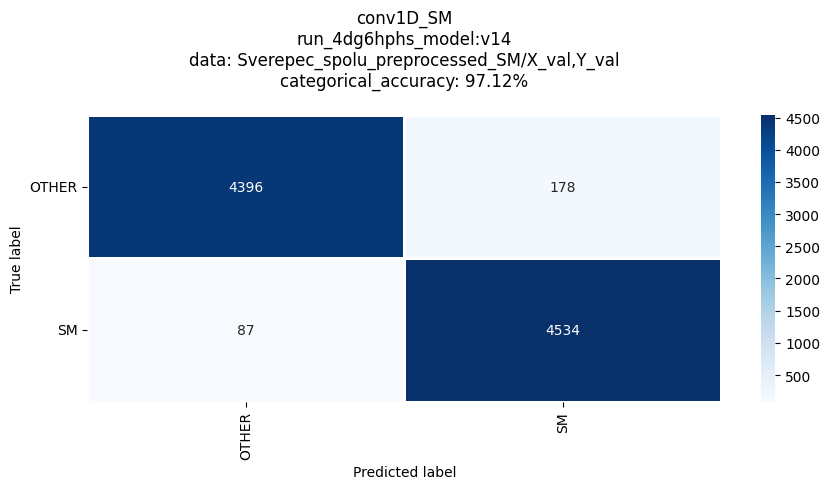

In [9]:
Y_pred = predict_model(model, X_val, Y_val, label_encoder=label_encoder)
cm = confusion_matrix(label_encoder.inverse_transform(np.argmax(Y_val, axis=1)), Y_pred)

eval_results = model.evaluate(X_val, Y_val, return_dict=True)
metric_name = 'categorical_accuracy'

fig, ax = plt.subplots(figsize=(9,5))
plot_cm(ax, cm, labels=label_encoder.classes_)
plt.title('%s\n%s\ndata: %s/X_val,Y_val\n%s: %.2f%%\n' % (
    cfg['model_name'],
    model_artifact.name,
    os.path.basename(cfg['data_dir']),
    metric_name,
    float(eval_results[metric_name]) * 100.0)
)
plt.tight_layout()
plt.savefig(os.path.join(cfg['data_dir'], 'cm-%s.pdf' % model_artifact.name), format='pdf')
plt.show()

In [10]:
tf.keras.utils.plot_model(
    model,
    to_file=os.path.join(cfg['data_dir'], '%s-arch.pdf' % model_artifact.name),
    expand_nested=True,
    show_shapes=True,
    show_layer_activations=True
)

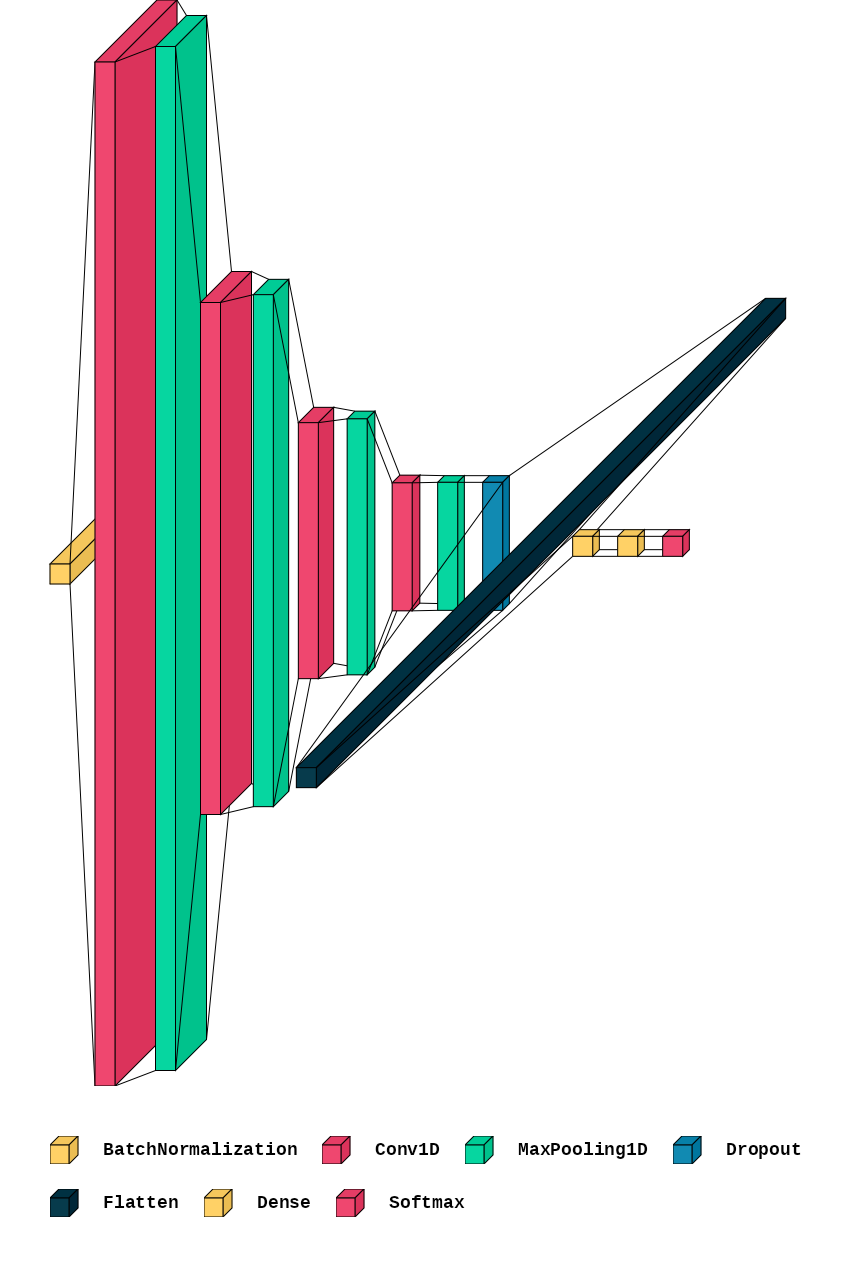

In [11]:
from PIL import ImageFont

font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 18)

visualkeras.layered_view(
    model,
    to_file=os.path.join(cfg['data_dir'], '%s-arch.png' % model_artifact.name),
    legend=True,
    scale_xy=1,
    scale_z=1,
    one_dim_orientation='x',
    padding=50,
    spacing=25,
    font=font
)